# Self-Improving RAG Agent

## Overview

Traditional RAG systems have a critical limitation: they retrieve documents once and then generate an answer based on those documents, regardless of their relevance. An agentic approach allows the system to adapt its retrieval strategy based on objective performance metrics.

This notebook provides a framework for evaluating agentic RAG systems.

## Setup

First, let's install the necessary libraries:

In [1]:
%pip install openai chromadb sentence_transformers pandas matplotlib numpy tqdm

Note: you may need to restart the kernel to use updated packages.


In [51]:
import openai
import chromadb
from chromadb.utils import embedding_functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import getpass
from tqdm import tqdm
from sentence_transformers import CrossEncoder
from typing import Optional, List, Dict, Type

# Display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# Define paths
DATA_DIR = "../data/papers"
EVAL_DIR = "../data/evalset"

# Initialize OpenAI and Chroma
openai.api_key = getpass.getpass('Enter your OpenAI API key: ')
chroma_client = chromadb.PersistentClient()

### Loading Evaluation Dataset

Let's load the eval set we created previously:

In [52]:
eval_df = pd.read_json('../data/evalset/ai_papers_eval_dataset.json')
print(f"Loaded {len(eval_df)} evaluation examples")
print(eval_df.head())

Loaded 26 evaluation examples
                  id                                                                                             document                                                                                                query                                                                                               answer
0  gpt_1.pdf_chunk_0  Improving Language Understanding\nby Generative Pre-Training\nAlec Radford\nOpenAI\nalec@openai....                             details on the generative pre-training methodology outlined in the paper  The document discusses a generative pre-training methodology that involves training a language m...
1  gpt_1.pdf_chunk_1  speciﬁc task. In contrast to previous approaches, we make use of task-aware input\ntransformatio...                                  details on the task-aware input transformations used in fine-tuning  The document mentions that task-aware input transformations are utilized during fine-tuning to a..

### Let's build our Agent

In [62]:
class RAGAgent:
    def __init__(self, collection, llm_model: str = "gpt-3.5-turbo", embedding_model: str = "text-embedding-3-small", reranker_model: Optional[str] = None):
        self.collection = collection
        self.llm_model = llm_model
        self.embedding_model = embedding_model
        self.reranker_model = reranker_model
        self.max_iterations = 3
        self.target_metrics = {"recall": 0.8, "mrr": 0.5}
        self.top_k = 10
        self.history = []
        # For tracking agent type in evaluations
        self.agent_type = self.__class__.__name__
        self.agent_config = {
            "llm_model": llm_model,
            "max_iterations": self.max_iterations,
            "top_k": self.top_k,
            "reranker_model": str(self.reranker_model),
        }

    def retrieve(self, query: str):
        results = self.collection.query(query_texts=[query], n_results=self.top_k)
        results = {"ids": results['ids'][0], "documents": results['documents'][0]}

        if self.reranker_model:
            cross_encoder = CrossEncoder(self.reranker_model)
            pairs = [(query, doc) for doc in results["documents"]]
            scores = cross_encoder.predict(pairs)
            reranked_indices = np.argsort(-scores)[:self.top_k]
            return {
                "ids": [results["ids"][i] for i in reranked_indices],
                "documents": [results["documents"][i] for i in reranked_indices]
            }

        return results
    
    def evaluate_retrieval(self, predictions: List[str], ground_truth: List[str]):
        metrics = {}

        def calculate_mrr(predictions: list[str], ground_truth: list[str]):
            mrr = 0
            for label in ground_truth:
                if label in predictions:
                    mrr = max(mrr, 1 / (predictions.index(label) + 1))
            return mrr
        
        def calculate_recall(predictions: list[str], ground_truth: list[str]):
            return len([label for label in ground_truth if label in predictions]) / len(ground_truth)
        
        for k in [1, 3, 5, 10]:
            metrics[f"mrr@{k}"] = calculate_mrr(predictions[:k], ground_truth)
            metrics[f"recall@{k}"] = calculate_recall(predictions[:k], ground_truth)

        return metrics
    
    def rewrite_query(self, query: str, retrieved_docs: List[str]):
        system_prompt = "You are an assistant that refines search queries to be precise and targeted for optimal document retrieval."
        user_message = f"Original query: {query}\n\n"
    
        if retrieved_docs:
            user_message += f"The following documents were retrieved but did not achieve good retrieval metrics:\n\n"
            for i, doc in enumerate(retrieved_docs[:3]):
                user_message += f"Document {i+1}:\n{doc}\n\n"
        user_message += f"Please rewrite the query to be more specific and targeted to improve retrieval performance. Return ONLY the reformulated query without any explanations or additional text."
    
        response = openai.chat.completions.create(
            model=self.llm_model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_message}
            ]
        )
    
        return response.choices[0].message.content.strip()    

    def generate_answer(self, query: str, documents: List[str]):
        context = "\n\n".join(documents)
        response = openai.chat.completions.create(
            model=self.llm_model,
            messages=[
                {"role": "system", "content": "You are an assistant that answers questions based on the provided context."},
                {"role": "user", "content": f"Context:\n{context}\n\nQuestion: {query}\n\nAnswer the question based on the context provided. If the context doesn't contain the answer, say 'I don't have enough information to answer this question.'"}
            ]
        )
        return response.choices[0].message.content
    
    def _is_target_achieved(self, metrics: Dict[str, float]) -> bool:
        recall_key = f"recall@{self.top_k}"
        mrr_key = f"mrr@{self.top_k}"
        
        current_recall = metrics.get(recall_key, 0)
        current_mrr = metrics.get(mrr_key, 0)
        
        target_recall = self.target_metrics.get("recall", 0)
        target_mrr = self.target_metrics.get("mrr", 0)

        return current_recall >= target_recall and current_mrr >= target_mrr
    
    def run(self, query: str, ground_truth: List[str] = None):
        current_query = query
        iteration = 0
        self.history = []
        best_metrics = {"recall@10": 0, "mrr@10": 0}
        best_retrieval = None

        for _ in range(self.max_iterations):
            # Retrieve documents
            retrievals = self.retrieve(current_query)
            documents = retrievals["documents"]
            predictions = retrievals["ids"]

            # Evaluate retrieval
            metrics = {}
            if ground_truth: 
                metrics = self.evaluate_retrieval(predictions, ground_truth)
            
            self.history.append({
                "iteration": iteration,
                "query": current_query,
                "retrieved_docs": documents,
                "predictions": predictions,
                "metrics": metrics
            })

            # Check if this is the best retrieval so far
            if ground_truth:
                recall_key = f"recall@{self.top_k}"
                mrr_key = f"mrr@{self.top_k}"
                if (metrics.get(recall_key, 0), metrics.get(mrr_key, 0)) >= (best_metrics.get(recall_key, 0), best_metrics.get(mrr_key, 0)):
                    best_metrics = metrics
                    best_retrieval = {
                        "documents": documents,
                        "predictions": predictions,
                        "query": current_query
                    }
            else:
                # Without ground truth, just use the latest retrieval
                best_retrieval = {
                    "documents": documents,
                    "predictions": predictions,
                    "query": current_query
                }

            # Check if we've met our targets or reached max iterations
            if not ground_truth or self._is_target_achieved(metrics) or iteration == self.max_iterations:
                print("Target metrics achieved or max iterations reached, generating answer...")
                
                # Use best retrieval if available, otherwise current retrieval
                final_docs = best_retrieval["documents"] if best_retrieval else documents
                final_query = best_retrieval["query"] if best_retrieval else current_query
                
                answer = self.generate_answer(query, final_docs)
                
                return {
                    "query": query,
                    "final_query": final_query,
                    "answer": answer,
                    "iterations": iteration,
                    "history": self.history,
                    "metrics": best_metrics,
                    "success": True if not ground_truth or self._is_target_achieved(metrics) else False
                }
            
            # Otherwise, reformulate the query and try again
            current_query = self.rewrite_query(query, documents[:3])
            print(f"Reformulated query: {current_query}")
        
        # This should not be reached due to the condition above
        return {
            "query": query,
            "final_query": current_query,
            "answer": "Processing error: Max iterations reached without generating an answer.",
            "iterations": iteration,
            "history": self.history,
            "metrics": best_metrics,
            "success": False
        }

In [65]:
class RAGEvaluator:
    def __init__(self, chroma_client):
        self.chroma_client = chroma_client
        self.collections = {} # cache
    
    def create_collection(self, collection_name: str, evalset: pd.DataFrame, embedding_model: str):
        cache_key = f"{collection_name}_{embedding_model}"
        if cache_key in self.collections:
            return self.collections[cache_key]
        
        print(f"Initializing collection {collection_name} with {len(evalset)} documents using {embedding_model}")

        # Initialize embedding function
        embedding_function = embedding_functions.OpenAIEmbeddingFunction(model_name=embedding_model, api_key=openai.api_key)
        
        # Delete collection if it exists
        try:
            self.chroma_client.delete_collection(name=collection_name)
            print(f"Deleted existing collection {collection_name}")
        except:
            print(f"No existing collection {collection_name} to delete")
        
        # Create new collection
        collection = self.chroma_client.create_collection(name=collection_name, embedding_function=embedding_function)

        # Add documents to collection
        for _, row in evalset.iterrows():
            collection.upsert(
                documents=[row['document']],
                ids=[row['id']],
                metadatas=[{'id': row['id'], 'query': row['query'], 'answer': row['answer']}]
            )
        
        print(f"Created collection {collection_name} with {collection.count()} documents using {embedding_model}")

        # Cache collection
        self.collections[cache_key] = collection
        return collection
    
    def create_agent_config(
        self, 
        agent_class: Type[RAGAgent], 
        embedding_model: str,
        reranker_model: Optional[str] = None,
        **agent_params
    ) -> Dict[str, Any]:
        """
        Create a configuration for an agent with specified parameters.
        
        Args:
            agent_class: The RAGAgent class to use
            embedding_model: The embedding model to use
            reranker_model: Optional reranker model
            **agent_params: Additional parameters for the agent
            
        Returns:
            Dictionary with agent configuration
        """
        return {
            'agent_class': agent_class,
            'embedding_model': embedding_model,
            'reranker_model': reranker_model,
            'params': agent_params
        }
    
    def evaluate_configurations(
        self,
        eval_df: pd.DataFrame,
        configurations: List[Dict[str, Any]],
        k_values: List[int] = [1, 3, 5, 10]
    ) -> pd.DataFrame:
        """
        Evaluate different agent configurations.
        
        Args:
            eval_df: DataFrame containing evaluation data
            configurations: List of agent configurations created with create_agent_config
            k_values: List of k values to evaluate
            
        Returns:
            DataFrame containing evaluation results
        """
        all_results = []
        
        # Evaluate each configuration
        for config in configurations:
            agent_class = config['agent_class']
            embedding_model = config['embedding_model']
            reranker_model = config['reranker_model']
            agent_params = config['params']
            
            # Create a descriptive name
            class_name = agent_class.__name__
            config_name = f"{class_name}-{embedding_model}"
            if reranker_model:
                config_name += f"-{reranker_model}"
            
            print(f"\nEvaluating configuration: {config_name}")
            
            # Create collection for this embedding model
            collection_name = f"eval_{embedding_model.replace('-', '_')}"
            collection = self.create_collection(
                collection_name,
                eval_df,
                embedding_model
            )
            
            # Create agent with this collection
            agent = agent_class(
                collection=collection,
                reranker_model=reranker_model,
                **agent_params
            )
            
            # Add embedding model to agent config for tracking
            agent.agent_config['embedding_model'] = embedding_model
            
            results = []
            
            # Run evaluation on this agent
            for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df), 
                               desc=f"Testing {config_name}"):
                query = row['query']
                ground_truth_id = [row['id']]
                
                # Process query with this agent
                result = agent.run(query, ground_truth_id)
                
                # Get the final metrics
                final_metrics = result.get('metrics', {})
                
                # Record results for each k value
                for k in k_values:
                    if f'recall@{k}' in final_metrics:
                        results.append({
                            'query_id': idx,
                            'config_name': config_name,
                            'agent_type': agent.agent_type,
                            'embedding_model': embedding_model,
                            'reranker_model': str(reranker_model),
                            'k': k,
                            'metric': 'recall',
                            'score': final_metrics[f'recall@{k}'],
                            'iterations': result.get('iterations', 1)
                        })
                        
                    if f'mrr@{k}' in final_metrics:
                        results.append({
                            'query_id': idx,
                            'config_name': config_name,
                            'agent_type': agent.agent_type,
                            'embedding_model': embedding_model,
                            'reranker_model': str(reranker_model),
                            'k': k,
                            'metric': 'mrr',
                            'score': final_metrics[f'mrr@{k}'],
                            'iterations': result.get('iterations', 1)
                        })
            
            all_results.extend(results)
        
        # Combine all results
        evaluation_df = pd.DataFrame(all_results)
        print(f"Evaluation complete with {len(evaluation_df)} data points")
        
        return evaluation_df
    
    def visualize_results(self, results_df: pd.DataFrame):
        """
        Create visualizations of evaluation results.
        
        Args:
            results_df: DataFrame containing evaluation results
        """
        import matplotlib.pyplot as plt
        
        # Calculate average scores by configuration and k value
        avg_results = results_df.groupby(['config_name', 'embedding_model', 'reranker_model', 'k', 'metric'])['score'].mean().reset_index()
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
        
        # Plot recall for different configurations
        recall_data = avg_results[avg_results['metric'] == 'recall']
        for config in recall_data['config_name'].unique():
            data = recall_data[recall_data['config_name'] == config]
            ax1.plot(data['k'], data['score'], marker='o', label=config)
        
        ax1.set_title("Recall@k for Different Configurations")
        ax1.set_xlabel("k")
        ax1.set_ylabel("Recall")
        ax1.grid(True)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Plot MRR for different configurations
        mrr_data = avg_results[avg_results['metric'] == 'mrr']
        for config in mrr_data['config_name'].unique():
            data = mrr_data[mrr_data['config_name'] == config]
            ax2.plot(data['k'], data['score'], marker='o', label=config)
        
        ax2.set_title("MRR@k for Different Configurations")
        ax2.set_xlabel("k")
        ax2.set_ylabel("MRR")
        ax2.grid(True)
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        plt.savefig('configuration_comparison.png')
        plt.show()
        
        # First, deduplicate to get one row per query and configuration
        unique_iterations = results_df.drop_duplicates(['query_id', 'embedding_model', 'reranker_model'])
        # Then group by embedding model and reranker
        iterations_by_config = unique_iterations.groupby(['embedding_model', 'reranker_model'])['iterations'].mean().reset_index()
        
        # Create a bar chart
        plt.figure(figsize=(14, 6))
        bars = plt.bar(
            range(len(iterations_by_config)), 
            iterations_by_config['iterations'],
            color='skyblue'
        )
        
        # Add labels
        plt.xticks(
            range(len(iterations_by_config)), 
            [f"{row['embedding_model']}-{row['reranker_model']}" for _, row in iterations_by_config.iterrows()],
            rotation=45,
            ha='right'
        )
        plt.title("Average Iterations Needed by Configuration")
        plt.xlabel("Configuration")
        plt.ylabel("Average Iterations")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Add value labels on top of bars
        for i, bar in enumerate(bars):
            plt.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.05,
                f"{bar.get_height():.2f}",
            ha='center'
        )
    
        plt.tight_layout()
        plt.savefig('iterations_by_config.png')
        plt.show()


        


Evaluating configuration: RAGAgent-text-embedding-3-small
Initializing collection eval_text_embedding_3_small with 26 documents using text-embedding-3-small
Deleted existing collection eval_text_embedding_3_small
Created collection eval_text_embedding_3_small with 26 documents using text-embedding-3-small


Testing RAGAgent-text-embedding-3-small:   0%|          | 0/26 [00:00<?, ?it/s]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:   4%|▍         | 1/26 [00:02<01:11,  2.85s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:   8%|▊         | 2/26 [00:04<00:58,  2.43s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  12%|█▏        | 3/26 [00:08<01:05,  2.87s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  15%|█▌        | 4/26 [00:10<00:57,  2.61s/it]

Reformulated query: Refined query: explain the unsupervised pre-training and supervised fine-tuning stages in the training procedure outlined in the paper
Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  19%|█▉        | 5/26 [00:15<01:09,  3.30s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  23%|██▎       | 6/26 [00:17<00:56,  2.85s/it]

Reformulated query: "Key findings and improvements achieved in natural language understanding tasks using task-aware input transformations and transfer learning"
Reformulated query: key findings and improvements achieved in natural language understanding tasks by utilizing task-aware input transformations and generative pre-training followed by discriminative fine-tuning.


Testing RAGAgent-text-embedding-3-small:  27%|██▋       | 7/26 [00:21<01:01,  3.23s/it]

Reformulated query: Revised query: "Demonstrated key improvements achieved through generative pre-training and discriminative fine-tuning on a diverse range of natural language understanding tasks in the discussed framework."
Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  31%|███       | 8/26 [00:24<00:57,  3.17s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  35%|███▍      | 9/26 [00:26<00:47,  2.82s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  38%|███▊      | 10/26 [00:31<00:56,  3.53s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  42%|████▏     | 11/26 [00:37<01:04,  4.30s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  46%|████▌     | 12/26 [00:39<00:52,  3.77s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  50%|█████     | 13/26 [00:41<00:41,  3.18s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  54%|█████▍    | 14/26 [00:43<00:33,  2.81s/it]

Reformulated query: Refined query: training parameters, optimization techniques, and regularization methods used in the supervision of a language model.
Reformulated query: Specific query refinement: training parameters and techniques employed for supervised fine-tuning in a Transformer-based language model


Testing RAGAgent-text-embedding-3-small:  58%|█████▊    | 15/26 [00:46<00:32,  2.95s/it]

Reformulated query: Refined query: training parameters and techniques in a neural network model for language understanding tasks
Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  62%|██████▏   | 16/26 [00:49<00:27,  2.76s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  65%|██████▌   | 17/26 [00:51<00:22,  2.46s/it]

Reformulated query: "performance of proposed model on semantic similarity and classification tasks across GLUE benchmark datasets"
Reformulated query: Performance evaluation of the proposed model compared to state-of-the-art methods on natural language inference datasets.
Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  69%|██████▉   | 18/26 [00:55<00:24,  3.11s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  73%|███████▎  | 19/26 [00:57<00:18,  2.70s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  77%|███████▋  | 20/26 [00:59<00:14,  2.41s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  81%|████████  | 21/26 [01:00<00:10,  2.18s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  85%|████████▍ | 22/26 [01:03<00:09,  2.43s/it]

Reformulated query: performance evaluation of Transformer and LSTM models in natural language understanding tasks
Reformulated query: - Refine query: "performance difference between Transformer and LSTM models on natural language understanding tasks with emphasis on pre-training and fine-tuning"


Testing RAGAgent-text-embedding-3-small:  88%|████████▊ | 23/26 [01:07<00:08,  2.75s/it]

Reformulated query: "Comparative analysis of performance metrics in natural language understanding tasks between Transformer and LSTM models with a focus on supervised fine-tuning and pre-training effects"
Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  92%|█████████▏| 24/26 [01:08<00:04,  2.31s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small:  96%|█████████▌| 25/26 [01:13<00:03,  3.18s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small: 100%|██████████| 26/26 [01:14<00:00,  2.88s/it]



Evaluating configuration: RAGAgent-text-embedding-3-large
Initializing collection eval_text_embedding_3_large with 26 documents using text-embedding-3-large
Deleted existing collection eval_text_embedding_3_large
Created collection eval_text_embedding_3_large with 26 documents using text-embedding-3-large


Testing RAGAgent-text-embedding-3-large:   0%|          | 0/26 [00:00<?, ?it/s]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:   4%|▍         | 1/26 [00:02<00:50,  2.01s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:   8%|▊         | 2/26 [00:04<00:48,  2.01s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  12%|█▏        | 3/26 [00:07<01:05,  2.85s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  15%|█▌        | 4/26 [00:11<01:09,  3.14s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  19%|█▉        | 5/26 [00:15<01:11,  3.41s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  23%|██▎       | 6/26 [00:18<01:05,  3.26s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  27%|██▋       | 7/26 [00:20<00:56,  3.00s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  31%|███       | 8/26 [00:23<00:53,  2.98s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  35%|███▍      | 9/26 [00:25<00:43,  2.54s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  38%|███▊      | 10/26 [00:28<00:45,  2.86s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  42%|████▏     | 11/26 [00:35<00:58,  3.93s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  46%|████▌     | 12/26 [00:37<00:46,  3.33s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  50%|█████     | 13/26 [00:39<00:38,  3.00s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  54%|█████▍    | 14/26 [00:41<00:33,  2.78s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  58%|█████▊    | 15/26 [00:45<00:32,  2.96s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  62%|██████▏   | 16/26 [00:48<00:32,  3.21s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  65%|██████▌   | 17/26 [00:50<00:25,  2.83s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  69%|██████▉   | 18/26 [00:53<00:21,  2.69s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  73%|███████▎  | 19/26 [00:54<00:16,  2.38s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  77%|███████▋  | 20/26 [00:56<00:12,  2.09s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  81%|████████  | 21/26 [00:58<00:10,  2.05s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  85%|████████▍ | 22/26 [00:59<00:07,  1.92s/it]

Reformulated query: Performance comparison between Transformer and LSTM in natural language tasks such as text classification and question answering.
Reformulated query: Comparison of performance metrics specifically in natural language understanding tasks between Transformer and LSTM models.


Testing RAGAgent-text-embedding-3-large:  88%|████████▊ | 23/26 [01:03<00:07,  2.36s/it]

Reformulated query: "Comparison of performance metrics such as accuracy and F1 scores between Transformer and LSTM models in natural language understanding tasks using the GLUE benchmark dataset"
Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  92%|█████████▏| 24/26 [01:04<00:04,  2.02s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large:  96%|█████████▌| 25/26 [01:07<00:02,  2.49s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large: 100%|██████████| 26/26 [01:09<00:00,  2.66s/it]



Evaluating configuration: RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:   0%|          | 0/26 [00:00<?, ?it/s]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:   4%|▍         | 1/26 [00:15<06:19, 15.18s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:   8%|▊         | 2/26 [00:18<03:21,  8.41s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  12%|█▏        | 3/26 [00:25<02:49,  7.39s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  15%|█▌        | 4/26 [00:29<02:17,  6.23s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  19%|█▉        | 5/26 [00:33<01:57,  5.61s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  23%|██▎       | 6/26 [00:37<01:39,  4.99s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  27%|██▋       | 7/26 [00:41<01:29,  4.70s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  31%|███       | 8/26 [00:46<01:22,  4.60s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  35%|███▍      | 9/26 [00:50<01:14,  4.37s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  38%|███▊      | 10/26 [00:53<01:07,  4.20s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  42%|████▏     | 11/26 [00:59<01:07,  4.48s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  46%|████▌     | 12/26 [01:02<00:56,  4.01s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  50%|█████     | 13/26 [01:05<00:51,  3.93s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  54%|█████▍    | 14/26 [01:10<00:51,  4.32s/it]

Reformulated query: Query refinement: training parameters and techniques used in unsupervised pre-training for language understanding tasks
Reformulated query: Query refinement: specific training parameters and techniques used in semi-supervised language understanding model training


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  58%|█████▊    | 15/26 [01:19<00:59,  5.45s/it]

Reformulated query: Revised query: training parameters and techniques for semi-supervised natural language processing (NLP) models
Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  62%|██████▏   | 16/26 [01:23<00:52,  5.29s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  65%|██████▌   | 17/26 [01:28<00:44,  4.98s/it]

Reformulated query: performance evaluation of the proposed transformer model on the GLUE benchmark dataset
Reformulated query: performance evaluation of the proposed model in natural language inference datasets


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  69%|██████▉   | 18/26 [01:35<00:46,  5.81s/it]

Reformulated query: Proposed query refinement: "comparing performance of a specific model on natural language inference datasets SNLI, MultiNLI, Question NLI, RTE, and SciTail"
Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  73%|███████▎  | 19/26 [01:39<00:35,  5.14s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  77%|███████▋  | 20/26 [01:43<00:29,  4.86s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  81%|████████  | 21/26 [01:46<00:21,  4.23s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  85%|████████▍ | 22/26 [01:52<00:18,  4.74s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  88%|████████▊ | 23/26 [01:56<00:13,  4.46s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  92%|█████████▏| 24/26 [01:59<00:08,  4.06s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2:  96%|█████████▌| 25/26 [02:05<00:04,  4.61s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2: 100%|██████████| 26/26 [02:07<00:00,  4.92s/it]



Evaluating configuration: RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:   0%|          | 0/26 [00:00<?, ?it/s]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:   4%|▍         | 1/26 [00:04<01:54,  4.59s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:   8%|▊         | 2/26 [00:08<01:39,  4.17s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  12%|█▏        | 3/26 [00:13<01:42,  4.47s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  15%|█▌        | 4/26 [00:18<01:40,  4.57s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  19%|█▉        | 5/26 [00:22<01:38,  4.69s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  23%|██▎       | 6/26 [00:28<01:38,  4.91s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  27%|██▋       | 7/26 [00:34<01:43,  5.45s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  31%|███       | 8/26 [00:38<01:28,  4.92s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  35%|███▍      | 9/26 [00:42<01:18,  4.59s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  38%|███▊      | 10/26 [00:46<01:10,  4.38s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  42%|████▏     | 11/26 [00:49<01:02,  4.13s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  46%|████▌     | 12/26 [00:53<00:53,  3.84s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  50%|█████     | 13/26 [00:56<00:49,  3.82s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  54%|█████▍    | 14/26 [00:59<00:43,  3.60s/it]

Reformulated query: Refined query: training parameters and techniques in transformer network for language modeling and supervised fine-tuning
Reformulated query: Refined query: training parameters and techniques of transformer-based neural network models for natural language understanding


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  58%|█████▊    | 15/26 [01:08<00:54,  4.99s/it]

Reformulated query: Revised query: training parameters and techniques used in a neural network model based on Transformer architecture for natural language understanding tasks
Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  62%|██████▏   | 16/26 [01:13<00:51,  5.18s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  65%|██████▌   | 17/26 [01:18<00:44,  4.95s/it]

Reformulated query: Comparison of the proposed model's performance on natural language understanding tasks using generative pre-training and discriminative fine-tuning across various datasets.
Reformulated query: Performance analysis of a proposed transformer model compared to a one-layer 2048 unit LSTM across various datasets


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  69%|██████▉   | 18/26 [01:27<00:48,  6.10s/it]

Reformulated query: performance of transformer model with pre-training compared to LSTM model on MRPC dataset
Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  73%|███████▎  | 19/26 [01:30<00:36,  5.19s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  77%|███████▋  | 20/26 [01:33<00:28,  4.68s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  81%|████████  | 21/26 [01:36<00:20,  4.20s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  85%|████████▍ | 22/26 [01:40<00:15,  4.00s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  88%|████████▊ | 23/26 [01:44<00:12,  4.04s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  92%|█████████▏| 24/26 [01:47<00:07,  3.91s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2:  96%|█████████▌| 25/26 [01:51<00:03,  3.69s/it]

Target metrics achieved or max iterations reached, generating answer...


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2: 100%|██████████| 26/26 [01:54<00:00,  4.42s/it]


Evaluation complete with 832 data points


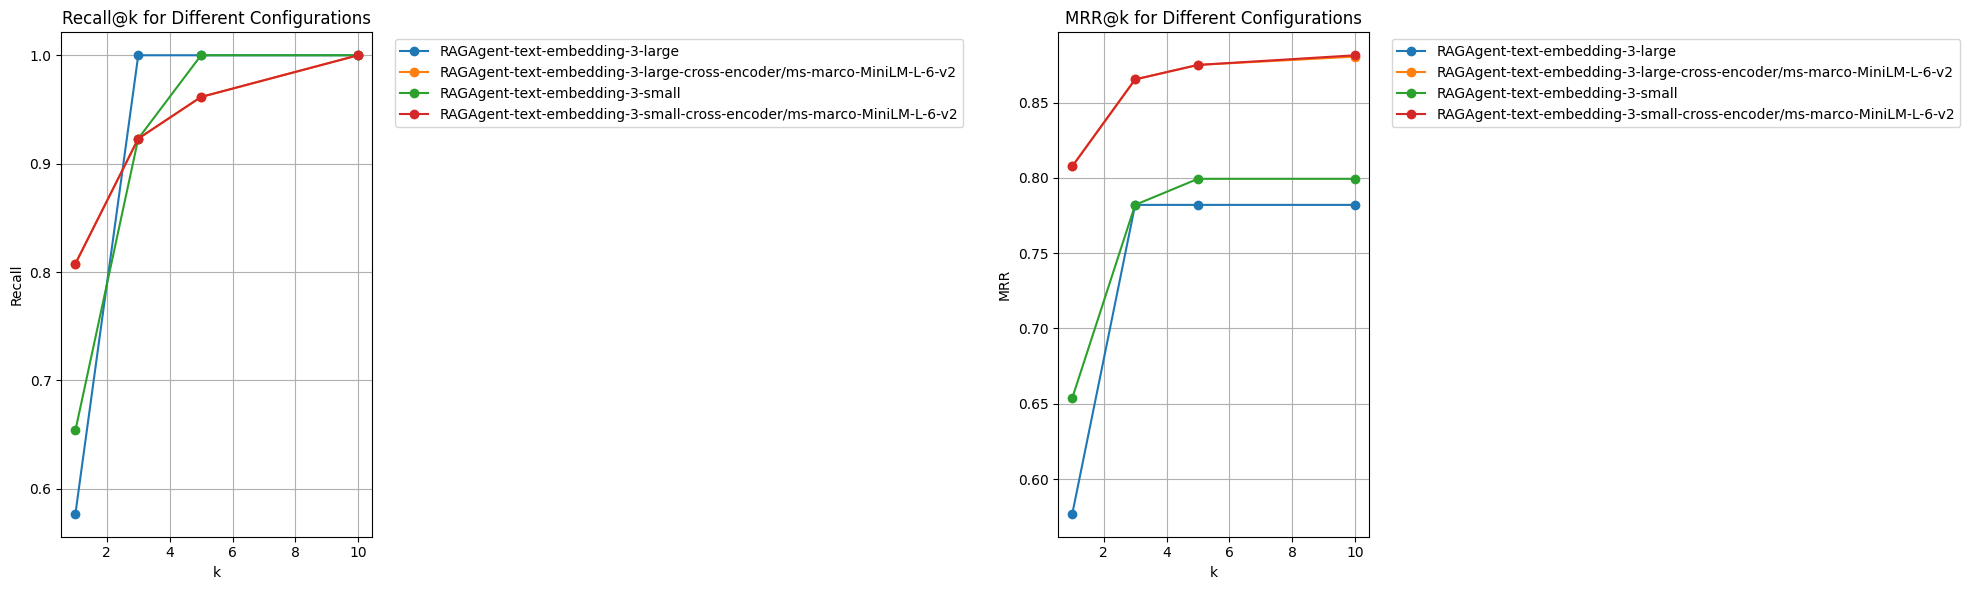

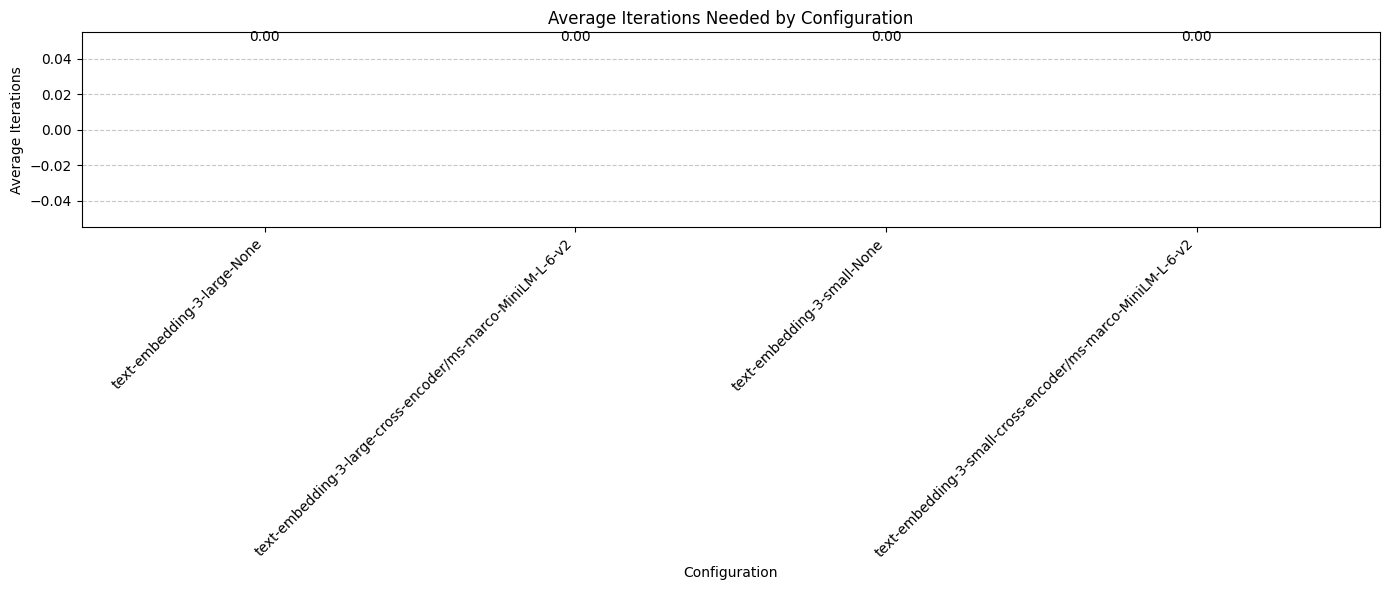

In [66]:
# Initialize evaluator
evaluator = RAGEvaluator(chroma_client)
    
# Create configs to evaluate
configs = [
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-small",
        reranker_model=None,
        llm_model="gpt-3.5-turbo"
    ),
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-large",
        reranker_model=None,
        llm_model="gpt-3.5-turbo"
    ),
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-large",
        reranker_model="cross-encoder/ms-marco-MiniLM-L-6-v2",
        llm_model="gpt-3.5-turbo"
    ), 
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-small",
        reranker_model="cross-encoder/ms-marco-MiniLM-L-6-v2",
        llm_model="gpt-3.5-turbo"
    )
]

evaluation_df = evaluator.evaluate_configurations(eval_df, configs)
evaluator.visualize_results(evaluation_df)


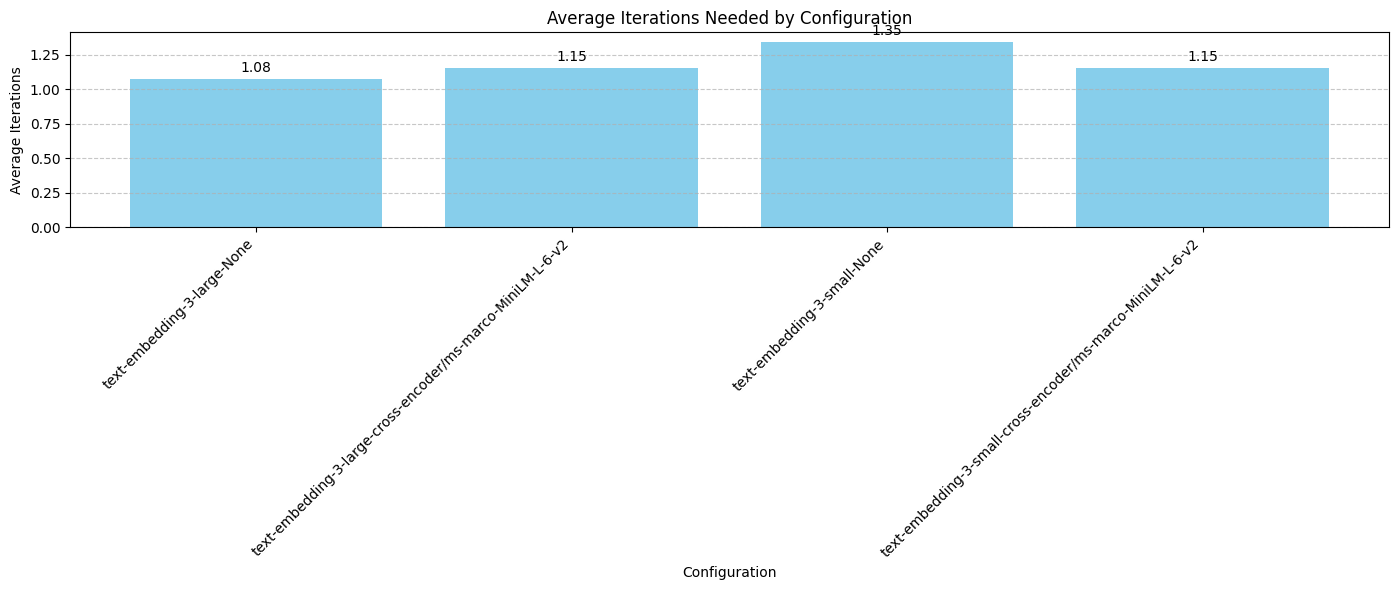

In [45]:
### Analyzing Number of Iterations by Configuration

# Calculate average iterations needed for each configuration
iterations_by_config = evaluation_df.groupby(['embedding_model', 'reranker_model'])['iterations'].mean().reset_index()

# Create a bar chart
plt.figure(figsize=(14, 6))
bars = plt.bar(
    range(len(iterations_by_config)), 
    iterations_by_config['iterations'],
    color='skyblue'
)

# Add labels
plt.xticks(
    range(len(iterations_by_config)), 
    [f"{row['embedding_model']}-{row['reranker_model']}" for _, row in iterations_by_config.iterrows()],
    rotation=45,
    ha='right'
)
plt.title("Average Iterations Needed by Configuration")
plt.xlabel("Configuration")
plt.ylabel("Average Iterations")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, bar in enumerate(bars):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.05,
        f"{bar.get_height():.2f}",
        ha='center'
    )

plt.tight_layout()
plt.savefig('iterations_by_config.png')
plt.show()